# NLP Model for Book Recommendation

## Word Embeddings

Word embedding is to build a NLP model that captures the semantic meanings of each word in a document. It creates word vectors and we can visualize the words in a vector space how are related to one another. 

In [1]:
#https://nijianmo.github.io/amazon/index.html#subsets

In [2]:
import os
#import json
import ujson as json
import gzip
import pandas as pd
from urllib.request import urlopen

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import base
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import RidgeCV, LinearRegression, SGDRegressor, Ridge
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from scipy.sparse import csr_matrix

In [77]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import re
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
from sklearn.decomposition import PCA
from spacy.lang.en.stop_words import STOP_WORDS
import spacy

In [6]:
df_tot = pd.read_csv('data/df_merge.csv')

In [7]:
df = df_tot[['reviewerID', 'asin', 'reviewText', 'overall', 'summary', 'unixReviewTime', 'description', 'title']]

In [8]:
df.head()

,reviewerID,asin,reviewText,overall,summary,unixReviewTime,description,title
0,A3RZNH3OPW1XMB,000171287X,for getting your kid introduced to his/her ABC...,5.0,Great,1375401600,"[""In the B Book, the youngest child will be en...",The Berenstains' B Book (Bright &amp; Early Bo...
1,AZGXZ2UUK6X,000171287X,"This Book is funny and is full of B words, lik...",3.0,A celebration of B,1061078400,"[""In the B Book, the youngest child will be en...",The Berenstains' B Book (Bright &amp; Early Bo...
2,A2K28JHMIY3XKZ,000171287X,A favorite Berenstain book of my children I wa...,5.0,Big B Believer,1001894400,"[""In the B Book, the youngest child will be en...",The Berenstains' B Book (Bright &amp; Early Bo...
3,A1Z54EM24Y40LL,000171287X,This book is quite funny. Especially when you...,5.0,"Very funny book, sad ending though!",1108080000,"[""In the B Book, the youngest child will be en...",The Berenstains' B Book (Bright &amp; Early Bo...
4,A179R0UL62Q36Z,000171287X,Teaching the next generation to love books! M...,5.0,Child's book,1345680000,"[""In the B Book, the youngest child will be en...",The Berenstains' B Book (Bright &amp; Early Bo...


In [9]:
df_unique_desc = df.groupby('asin', as_index=False, sort=False).last()

### Preprocessing

We want to clean data a bit to keep meaningful text and make it easy to tokenize.

In [10]:
#Utitlity functions for removing ASCII characters, converting lower case, removing stop words, html and punctuation from description

def remove_non_ascii(s):
    return "".join(i for i in s if ord(i)<128)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    text = [w for w in text if not w in STOP_WORDS]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

df['cleaned_desc'] = df['description'].apply(remove_non_ascii)
#df['cleaned_desc'] = df.cleaned_desc.apply(make_lower_case)
#df['cleaned_desc'] = df.cleaned_desc.apply(remove_stop_words)
df['cleaned_desc'] = df.cleaned_desc.apply(remove_html)


<ipython-input-10-d184295911a9>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_desc'] = df['description'].apply(remove_non_ascii)
<ipython-input-10-d184295911a9>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_desc'] = df.cleaned_desc.apply(remove_html)


In [11]:
df['reviewText'] = df['reviewText'].fillna('')

<ipython-input-11-cb6d36f0c3ae>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reviewText'] = df['reviewText'].fillna('')


In [12]:
df['cleaned_review'] = df['reviewText'].apply(remove_non_ascii)
#df['cleaned_review'] = df.cleaned_review.apply(make_lower_case)
#df['cleaned_review'] = df.cleaned_review.apply(remove_stop_words)
df['cleaned_review'] = df.cleaned_review.apply(remove_html)

<ipython-input-12-218b44b82874>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_review'] = df['reviewText'].apply(remove_non_ascii)
<ipython-input-12-218b44b82874>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_review'] = df.cleaned_review.apply(remove_html)


For the tokenization, we use gensim's simple_preprocess here, which removes punctuations and change the words to lower cases.

In [13]:
# I should break each description into sentences here. 
def process_review(review):
    """
    Splits review into sentences, then sentences into tokens. Returns 
    nested list.
    """
    words = [simple_preprocess(sentence, deacc=True) 
             for sentence in re.split('\.|\?|\!', review)
             if sentence]
    return words

# Flatten list to contain all sentences from all descriptions
sentences_desc = [sentence for description in df.cleaned_desc for sentence in process_review(description)]

In [14]:
# Flatten list to contain all sentences from all reviews
sentences_review = [sentence for review in df.cleaned_review for sentence in process_review(review)]

In [ ]:
from pprint import PrettyPrinter

# To format nested list
pp = PrettyPrinter(indent=2)
pp.pprint(sentences_desc[97:100])

In [ ]:
pp.pprint(sentences_review[97:100])

## Predict Sentiment of Reviews

I first want to check wheter I can extract sentiment from each review. This is also to indirectly check(?) the validity of the Word2Vec model.

In [15]:
# Read subset into DataFrame. Add sentiment column.
df['positive'] = df['overall'].apply(lambda x: 1 if x>=4 else 0)
df['neutral'] = df['overall'].apply(lambda x: 1 if x<4 and x >=3 else 0)
df['negative'] = df['overall'].apply(lambda x: 1 if x<=3 else 0)

<ipython-input-15-8f1eb267e2f9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['positive'] = df['overall'].apply(lambda x: 1 if x>=4 else 0)
<ipython-input-15-8f1eb267e2f9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['neutral'] = df['overall'].apply(lambda x: 1 if x<4 and x >=3 else 0)
<ipython-input-15-8f1eb267e2f9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

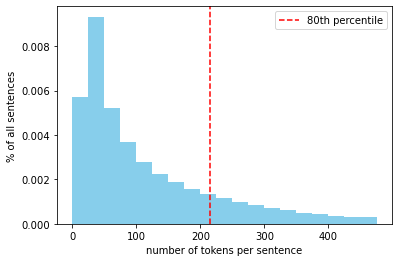

In [19]:
data = df['cleaned_review'].apply(lambda r: len(simple_preprocess(r)))

percentile = 80

plt.hist(data, bins=range(0, 500, 25), density=True, color= "skyblue", lw=0.1)
plt.axvline(np.percentile(data, percentile), 
            color='red', ls='--', label=f'{percentile}th percentile')
plt.xlabel('number of tokens per sentence')
plt.ylabel('% of all sentences')
plt.legend();

Roughly 200 tokens (words) are in one sentence for 80% of reviews. We will truncate the length of reviews accordingly.

### Word Embedding
Now we want to train a word2vec model with the tokenized words in all reviews. 

In [ ]:
w2v_review = Word2Vec(sentences_review,
               workers=4,   # Worker threads (=faster w/ multicore)
               vector_size=30,    # Dimensionality of word vectors
               window=5,    # Window size
               min_count=3, # Ignore words with frequency lower than this
               sample=1e-3) # Threshold for which higher-frequency 
                            # words are randomly downsampled

w2v_review.save('review_children_books_w2v.model')

In [16]:
w2v_review = Word2Vec.load('review_children_books_w2v.model')

In [17]:
def vectorize_reviews(data, maxlen=100, embedding_dim=30):
    """
    Tokenizes reviews, truncates the number of tokens if more than `maxlen`, 
    and vectorizes each token. Returns a three-dimensional array of shape
    n reviews x `maxlen` x `embedding_dim`. 
    """
    # Create empty array
    vectorized_data = np.zeros(shape=(len(data), maxlen, embedding_dim))
    
    for row, review in enumerate(data):
        # Preprocess each review
        tokens = simple_preprocess(review)
        
        # Truncate long reviews
        if len(tokens) > maxlen:
            tokens = tokens[:maxlen]
        
        # Get vector for each token in review
        for col, token in enumerate(tokens):
            try:
                word_vector = w2v_review.wv[token]
                # Add vector to array
                vectorized_data[row, col] = word_vector[:embedding_dim]
            except KeyError:
                pass
    
    return vectorized_data

maxlen = 100        # Our predetermined limit
embedding_dim = 30 # The first 30 values in our w2v vectors

X = vectorize_reviews(df.cleaned_review, maxlen, embedding_dim)
y = df.positive.values.reshape(-1,1)

print('Shape of feature matrix:', X.shape)
print('Shape of target vector:', y.shape)

Shape of feature matrix: (396159, 100, 30)
Shape of target vector: (396159, 1)


## Training data with GRU (Gated Recurrent Units) model

GRU is a part of a specific model of RNN (Recurrent Neural Network), which is in comparison effective in retaining long term memory and also efficient and fast in operation.

In [17]:
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.models import Sequential
         
maxlen=100
embedding_dim=30

gru_model = Sequential([
    GRU(128, return_sequences=True, input_shape=(maxlen, embedding_dim)),
    Dropout(0.25),
    GRU(64),
    Dropout(0.25),
    Dense(1, activation='sigmoid')
])

gru_model.save("gru_weights_review_maxlen_100_exbeddingDim_30.h5")
#gru_model.save("gru_weights_review_maxlen_200_exbeddingDim_30.h5")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100, 128)          61440     
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 98,753
Trainable params: 98,753
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
gru_model.load_weights("gru_weights_review_maxlen_100_exbeddingDim_30.h5")

## Evaluating our GRU model for sentiment extraction

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [ ]:
gru_model.compile(loss='binary_crossentropy', 
                  metrics=['accuracy'], 
                  optimizer='adam')

history = gru_model.fit(X_train, y_train, epochs=1, validation_split=0.1)

In [ ]:
# Positive
my_pos_review = """this book is amazing"""

# Negative
my_neg_review = """boring, does not capture attention"""

In [ ]:
# Vectorize reviews
test_vec = vectorize_reviews([my_pos_review, my_neg_review])

# Generate predictions
prediction = gru_model.predict(test_vec)

print(prediction)

We can predict the sentiment of each review with the accuracy of ~76%. Now let's explore how words are symantically related in a vector space.


### 1. Description

First, let's train the descriptions with Word2Vec and explore how each word maps in 2D space

In [ ]:
w2v_desc = Word2Vec(sentences_desc,
               workers=4,   # Worker threads (=faster w/ multicore)
               vector_size=30,    # Dimensionality of word vectors
               window=5,    # Window size
               min_count=3, # Ignore words with frequency lower than this
               sample=1e-3) # Threshold for which higher-frequency 
                            # words are randomly downsampled

w2v_desc.save('description_books_w2v.model')

In [ ]:
#w2v_desc = Word2Vec.load('description_books_w2v.model')

In [ ]:
# Collect vectors for n most common words in vocabulary
n = 500
vocabulary = [word for word in list(w2v_desc.wv.index_to_key) #[word for word in w2v.wv.vocab.keys() 
              if word not in STOP_WORDS][:n]
#vocabulary = sorted(vocabulary, key=lambda x: -w2v.wv.index_to_key[x].count)[:n]
#vocabulary = sorted(vocabulary, key=lambda x: -w2v.wv.vocab[x].count)[:n]
vectors = w2v_desc.wv[vocabulary]

# Reduce vector dimensionality from 30 to 2
pca = PCA(n_components=2, random_state=42)
vectors_t = pca.fit_transform(vectors)

# Put transformed vectors into DataFrame
vocab_df = pd.DataFrame(vectors_t, columns=['x', 'y']).assign(word=vocabulary)

# Print head
vocab_df.head()

In [ ]:
from bokeh.io import output_notebook, show
from bokeh.models import BoxZoomTool, ColumnDataSource, HoverTool, ResetTool
from bokeh.models.annotations import Span, Label
from bokeh.plotting import figure
output_notebook()

# Helper function
def get_coords(word):
    """Given a word from `vocab_df`, returns tuple with x, y coordinates."""
    coords = vocab_df[vocab_df['word'] == word][['x', 'y']]
    return list(coords.itertuples(name=None, index=False))[0]

# Create plot
p = figure(plot_width=700, 
           plot_height=400,
           tools=[HoverTool(tooltips='@word'), BoxZoomTool(), ResetTool()],
           title='Book Description Vocabulary')

# Add vocabulary
source = ColumnDataSource(vocab_df)
p.circle('x', 'y', source=source, size=5, 
         fill_color='blue', fill_alpha=0.3, 
         hover_fill_color='yellow')

# Add verticle and horizontal lines
line_x, line_y = get_coords('story')

vline = Span(location=line_x, dimension='height', 
             line_dash='dashed', line_color='red')
p.add_layout(vline)

hline = Span(location=line_y, dimension='width', 
             line_dash='dashed', line_color='red')
p.add_layout(hline)

# Display plot
show(p)

In [ ]:
def square_rooted(x):
    """Helper function for `cosine_similarity()`"""
    return sum([a * a for a in x])**0.5
  
# def cosine_similarity(word1, word2):
#     """
#     Given two words in `vocab_df` DataFrame, returns cosine similarity of word
#     vectors.
#     """
#     vec1, vec2 = get_coords(word1), get_coords(word2)
#     numerator = sum(a * b for a, b in zip(vec1, vec2))
#     denominator = square_rooted(vec1) * square_rooted(vec2)
#     return numerator/denominator

print('Cosine similarity for STORY and CHARACTERS  (PCA):', 
      cosine_similarity('story', 'characters'))

print('Cosine similarity for STORY and SHORT (PCA):', 
      cosine_similarity('story', 'short'))

In [ ]:
print('Cosine similarity for STORY and CHARACTERS  (FULL W2V):',
      w2v_desc.wv.similarity('story', 'characters'))

print('Cosine similarity for STORY and SHORT (FULL W2V):',
      w2v_desc.wv.similarity('story', 'short'))

In [ ]:
w2v_desc.wv.most_similar('problem')

## Vectorize the Text Reviews by Each Book

So far, we created word vectors for each word in reviews and in descriptions. Now we want to combine these vectors to get one vector for each book.

In [ ]:
#df.groupby('asin')['reviewText'].apply(list).to_dict()

In [19]:
df_unique_desc.head()

,asin,reviewerID,reviewText,overall,summary,unixReviewTime,description,title
0,000171287X,A2GLWCPW4DI9DX,I remember this beloved book from when I was a...,5.0,"The classic! A positive, fun lift for any time...",1380931200,"[""In the B Book, the youngest child will be en...",The Berenstains' B Book (Bright &amp; Early Bo...
1,0001714538,A6HXFDIC7DVTC,Another one of the Berenstain Bears Early Read...,4.0,Fun book,1238716800,"['By Stan Berenstain, Illustrated by Stan Bere...",The Berenstain Bears On the Moon (Bright and E...
2,0006479286,A1CCEOOK2M6BI0,The delivry was fast. The book was fantastic ...,5.0,good book,1342828800,"[""'STEPHEN KING MEETING WITH RUTH RENDELL' - F...",On the Edge of Darkness
3,0006485944,A3532D080M9CL8,"I'm not sure what drew me to this book, but up...",5.0,An unexpected surprise!,1355097600,['Grade 6-9-In a bone-dry summer during the Gr...,Dust
4,0006547192,AUTBHG6070SL4,Lessing's criticism of the twentieth century i...,3.0,"Like the series, but ...",1075075200,"[""'Magnificent...an astounding book that sets ...",Shikasta : Re-Colonised Planet 5


In [20]:
df_merge_review = df.groupby('asin')['reviewText'].apply(list).to_frame()
df_merge_review = pd.merge(df_merge_review, df_unique_desc[['asin', 'description']], how='inner', on='asin')

In [ ]:
# add the average rating for each book
df_merge_review = pd.merge(df_merge_review, df.groupby('asin')['overall'].mean().to_frame(), how='inner', on='asin')

In [ ]:
df_merge_review['reviewText'] = df_merge_review['reviewText'].apply(lambda x: ' '.join(x))

In [ ]:
df_merge_review['description'] = df_merge_review['description'].apply(lambda x: x[1:-2])

In [ ]:
df_merge_review.head()

In [ ]:
df_merge_review.to_csv('data/df_merge_review.csv', index=False) 

In [21]:
df_merge_review = pd.read_csv('data/df_merge_review_title.csv')

In [38]:
w2v_review_each_book = Word2Vec(sentences_review,
               workers=4,   # Worker threads (=faster w/ multicore)
               vector_size=30,    # Dimensionality of word vectors
               window=5,    # Window size
               min_count=3, # Ignore words with frequency lower than this
               sample=1e-3) # Threshold for which higher-frequency 
                            # words are randomly downsampled

w2v_review_each_book.save('combined_review_children_books_w2v.model')

In [39]:
def vectorize_combined_reviews(data, maxlen=100, embedding_dim=30):
    """
    Tokenizes reviews, truncates the number of tokens if more than `maxlen`, 
    and vectorizes each token. Returns a three-dimensional array of shape
    n reviews x `maxlen` x `embedding_dim`. 
    """
    # Create empty array
    vectorized_data = np.zeros(shape=(len(data), maxlen, embedding_dim))
    
    for row, review in enumerate(data):
        # Preprocess each review
        tokens = simple_preprocess(review)
        
        # Truncate long reviews
        if len(tokens) > maxlen:
            tokens = tokens[:maxlen]
        
        # Get vector for each token in review
        for col, token in enumerate(tokens):
            try:
                word_vector = w2v_review_each_book.wv[token]
                # Add vector to array
                vectorized_data[row, col] = word_vector[:embedding_dim]
            except KeyError:
                pass
    
    return vectorized_data

maxlen = 100        # Our predetermined limit
embedding_dim = 30 # The first 30 values in our w2v vectors

X = vectorize_combined_reviews(df_merge_review.reviewText, maxlen, embedding_dim)

print('Shape of feature matrix:', X.shape)

Shape of feature matrix: (21951, 100, 30)


In [40]:
# calculate mean of vectors for each book
average_vec = []

for i in range(len(X)):
    average = np.mean(X[i], axis=0)
    average_vec.append(average)

In [54]:
average_vec[0]

array([ 1.74961967,  0.20854406,  1.36508307,  0.89281046, -0.25358444,
       -0.9230866 , -0.99924648,  0.56569635, -0.18658994,  0.96578283,
       -0.31777611, -1.29112451,  1.10610055,  0.12416214,  1.09634157,
        0.72582806, -1.00239424,  1.56614611, -0.008306  ,  0.90678533,
       -0.09713234,  0.56218428,  0.28531339,  1.62575801,  0.45146213,
        0.05547156,  0.16414765,  1.37443876, -0.68329014,  0.84266695])

In [42]:
len(average_vec)

21951

In [43]:
# Collect vectors for n most common words in vocabulary
#nlp = spacy.load("en_core_web_sm")
# Collect vectors for n most common words in vocabulary
n = 500
vocabulary_review = [word for word in list(w2v_review_each_book.wv.index_to_key) #[word for word in w2v.wv.vocab.keys() 
              if word not in STOP_WORDS][:n]
vocabulary_review = [book for book in list(average_vec)]
#vocabulary = sorted(vocabulary, key=lambda x: -w2v.wv.index_to_key[x].count)[:n]
#vocabulary = sorted(vocabulary, key=lambda x: -w2v.wv.vocab[x].count)[:n]
vectors = w2v_review_each_book.wv[vocabulary_review]

# Reduce vector dimensionality from 30 to 2
pca = PCA(n_components=2, random_state=42)
vectors_t = pca.fit_transform(vectors)

# Put transformed vectors into DataFrame
vocab_df_review = pd.DataFrame(vectors_t, columns=['x', 'y']).assign(word=vocabulary_review)

# Print head
vocab_df_review.head()

,x,y,word
0,-7.233059,-3.829195,book
1,4.277613,-6.684560,read
2,-9.003922,-0.692505,story
3,4.804716,-6.337422,like
4,-7.259346,-4.087783,books


In [74]:
w2v_review_each_book.wv['story']

array([ 2.0580502 , -2.1748219 ,  6.211654  ,  0.8764504 ,  3.1389542 ,
       -0.7404901 , -0.89133596,  2.6319623 ,  1.5758806 ,  1.8861952 ,
        1.1342572 , -6.617124  ,  0.28347853, -1.875129  , -0.7811584 ,
        4.0745735 , -6.147056  ,  2.532177  , -0.9055427 , -1.2474566 ,
       -0.90625554,  2.8521867 ,  3.810676  ,  1.9543322 ,  0.34781027,
       -0.752659  ,  4.9458404 ,  2.6059577 ,  1.5508252 ,  2.9407253 ],
      dtype=float32)

In [75]:
# Recommending the Top 5 similar books

def recommendations_wv(title):
    # finding cosine similarity for the vectors
    cosine_similarities = cosine_similarity(average_vec, average_vec)

    books = df_merge_review[['title']]
    #Reverse mapping of the index
    indices = pd.Series(df_merge_review.index, index = df_merge_review['title']).drop_duplicates()
         
    idx = indices[title]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]
    book_indices = [i[0] for i in sim_scores]
    recommend = books.iloc[book_indices]
    for index, row in recommend.iterrows():
        print(row['title'])

In [78]:
recommendations_wv('The Snowy Day')

Kids Go!
Boats: Speeding! Sailing! Cruising!
Cats' Night Out (Paula Wiseman Books)
Ballpark
One Little Match


In [44]:
from bokeh.io import output_notebook, show
from bokeh.models import BoxZoomTool, ColumnDataSource, HoverTool, ResetTool
from bokeh.models.annotations import Span, Label
from bokeh.plotting import figure
output_notebook()

# Helper function
def get_coords_review(word):
    """Given a word from `vocab_df_review`, returns tuple with x, y coordinates."""
    coords = vocab_df_review[vocab_df_review['word'] == word][['x', 'y']]
    return list(coords.itertuples(name=None, index=False))[0]

# Create plot
p = figure(plot_width=700, 
           plot_height=400,
           tools=[HoverTool(tooltips='@word'), BoxZoomTool(), ResetTool()],
           title='Book Reviews Vocabulary')

# Add vocabulary
source = ColumnDataSource(vocab_df_review)
p.circle('x', 'y', source=source, size=5, 
         fill_color='blue', fill_alpha=0.3, 
         hover_fill_color='yellow')

# Add verticle and horizontal lines
line_x, line_y = get_coords_review('story')

vline = Span(location=line_x, dimension='height', 
             line_dash='dashed', line_color='red')
p.add_layout(vline)

hline = Span(location=line_y, dimension='width', 
             line_dash='dashed', line_color='red')
p.add_layout(hline)

# Display plot
show(p)

Loading BokehJS ...